In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

PATH = os.getcwd()
for _ in range(2):
    PATH = os.path.dirname(PATH)

if PATH not in sys.path:
    sys.path.append(PATH)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from BusinessAnalyticsProject.dataset.feature_engineering import train_test_split, select_features
from BusinessAnalyticsProject.models.model_selection import metrics
from BusinessAnalyticsProject.models.model_interpretation import (
    show_metrics,
    show_permutation_importance_corr,
    show_prediction_time_series,
    show_cv_test_results
)

In [4]:
sns.set_theme()
# warnings.filterwarnings("ignore")

## Read in Features

In [5]:
all_train_df = pd.read_csv("../data/processed/all_train.csv", index_col=[0], parse_dates=["Date"])
all_test_df = pd.read_csv("../data/processed/all_test.csv", index_col=[0], parse_dates=["Date"])

X_train, y_train, weights_train, X_test, y_test, weights_test = train_test_split(all_train_df)
X_train.shape, y_train.shape, weights_train.shape, X_test.shape, y_test.shape, weights_test.shape

((294132, 15), (294132,), (294132,), (127438, 15), (127438,), (127438,))

In [6]:
X_test_sub = train_test_split(all_test_df, "20200101", False)[0]
X_test_sub.shape, all_test_df.shape

((115064, 15), (115064, 22))

In [7]:
X_test_dates = all_train_df.Date[all_train_df.Date >= "20120101"]
X_test_dates

100      2012-01-06
243      2012-01-06
386      2012-01-06
529      2012-01-06
672      2012-01-06
            ...    
421012   2012-10-26
421146   2012-10-26
421289   2012-10-26
421434   2012-10-26
421569   2012-10-26
Name: Date, Length: 127438, dtype: datetime64[ns]

## All Metrics and Permutation Importance Rank Corr

In [8]:
results_dir = "../outputs/models/metrics_and_perm_importance/"
metrics_df = show_metrics(results_dir)
metrics_df

,r2_score,rmse,rwmse
LGBM,0.915887,6415.420302,2.517010e+06
XGB,0.908859,6678.086450,2.616876e+06
RF,0.907204,6738.417400,2.659558e+06
CB,0.903905,6857.154314,2.708537e+06
HGBR,0.889555,7351.345694,2.897050e+06


In [9]:
cv_test_df = show_cv_test_results(results_dir)
cv_test_df

,cross_val,test_set
LGBM,0.902921,0.915887
XGB,0.900009,0.908859
HGBR,0.895640,0.889555
CB,0.891896,0.903905
RF,0.879621,0.907204


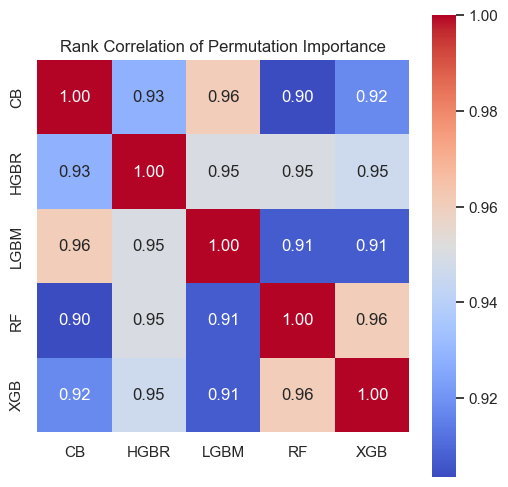

In [10]:
fig, axis = show_permutation_importance_corr(results_dir)

## Prediction by the Best Model

In [11]:
with open("../outputs/models/LGBM/cv_model_and_metrics.pkl", "rb") as rf:
    models_all = pickle.load(rf)

pipeline = models_all["model"].best_estimator_
pipeline

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('dummy',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function identity at 0x0000024F635384C0>))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024F00140DF0>),
                                                 ('continuous',
                                                  Pipeline(steps=[('dummy',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function identity at 0x0000024F635384C0>))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024F00140EE0>)])),
                ('model',
                 LGBMRegressor(categorical_feature='',
                               categorical_features=['Dept', 'Type',
                                                     'Holiday_type'],
                               min_child_samples=50, num_leaves=255,
                               reg_alpha=0.01, reg_lambda=1.0,
                               subsample=0.8))])

D:\python\venvs\BusinessAnalytics\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\python\venvs\BusinessAnalytics\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 1420, in _execute_child
    hp, ht, pid, tid = _winapi.

[LightGBM] [Warning] categorical_feature is set=, categorical_features=Dept,Type,Holiday_type will be ignored. Current value: categorical_feature=


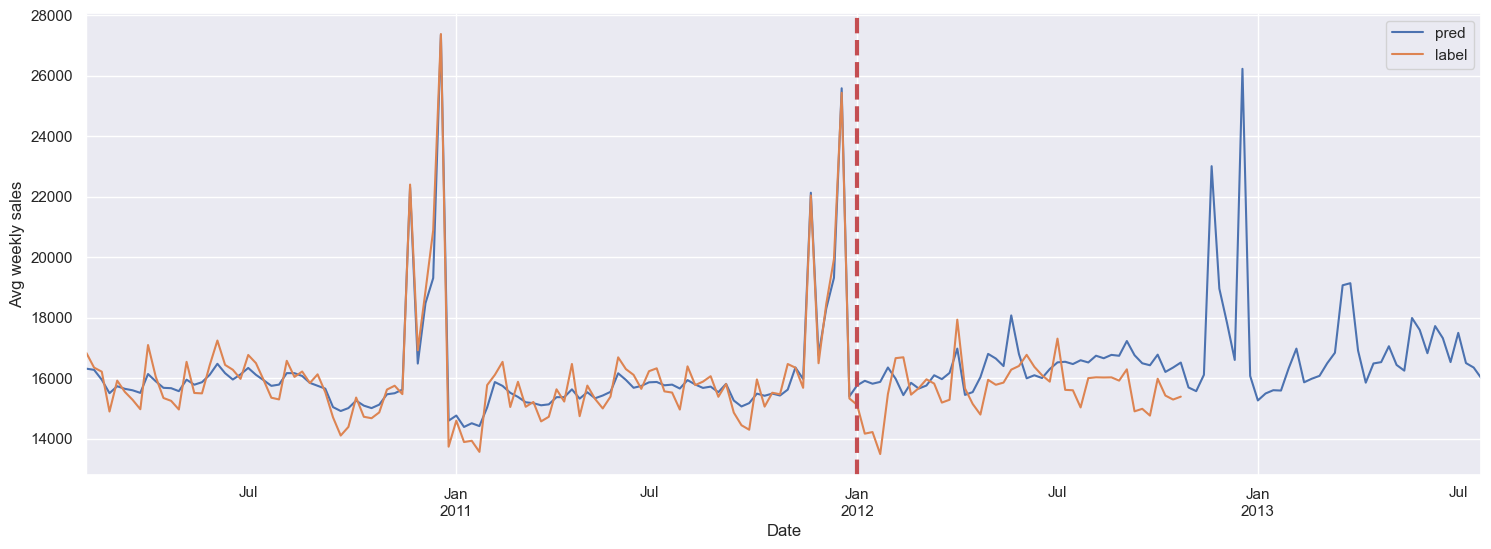

In [12]:
X_all = pd.concat([X_train, X_test, X_test_sub])
y_all = pd.concat([y_train, y_test])
all_dates = pd.concat([all_train_df.Date, all_test_df.Date])
fig, axis = show_prediction_time_series(pipeline, X_all, y_all, all_dates, "../outputs/evaluation")